### Set paths and Import libraries 

In [15]:
import os
import sys
# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
csvpath = '~/code/nn_orthoreplay/' #  path to the csv files


import numpy as np
import pdb; 
import matplotlib.pyplot as plt
from matplotlib import cm  # Import cm for colormap functionality
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
# Import helper functions from stateformation_get_input_output.py:
from stateformation_get_input_output_passive_block import get_input_output_stateformation
from stateformation_get_input_output_passive_block import get_active_trials_input_comb
from stateformation_get_input_output_passive_block import rewardfun
from stateformation_get_input_output_passive_block import input2state

# which subjects to use (set to subset to increase speed ...)
subjs = ['sub503', 'sub504', 'sub505', 'sub506', 'sub507'] 

allsubjs = ['sub501', 'sub502', 'sub503', 'sub504', 'sub505', 'sub506', 'sub507', 'sub508', 'sub509', 'sub510',
 'sub511', 'sub512', 'sub513', 'sub514', 'sub515', 'sub516', 'sub517', 'sub518', 'sub519', 
  'sub521', 'sub522', 'sub523', 'sub524', 'sub525', 'sub526', 'sub527', 'sub528', 'sub529', 'sub530', 
  'sub531', 'sub532', 'sub533', 'sub534', 'sub535', 'sub536', 'sub537', 'sub538', 'sub539', 'sub540', 
  'sub541', 'sub542', 'sub543', 'sub544', 'sub545', 'sub546', 'sub547', 'sub548', 'sub549', 'sub550', 
  'sub551', 'sub552', 'sub553', 'sub554', 'sub555', 'sub556', 'sub557', 'sub558', 'sub559', 'sub560', 
  'sub561', 'sub562', 'sub563', 'sub564'] 



### Define Custom functions for averaging etc 

In [16]:
# Function to compute running average
def running_average(data, window_size):
    kernel = np.ones(window_size) / window_size
    if data.ndim == 1:  # For 1D arrays
        return np.convolve(data, kernel, mode='valid')
    elif data.ndim == 2:  # For 2D arrays
        return np.array([np.convolve(row, kernel, mode='valid') for row in data])
    else:
        raise ValueError("Input data must be 1D or 2D.")

# Function to compute marginal means
def prep_marginal_means(cdim, loss_array, acc_array, window_size=15):
    """
    Compute running averages for loss and accuracy based on the specified dimension (cdim).

    Args:
        cdim (int): The dimension to marginalize over (0 for learning rates, 1 for RNN gains, 2 for FC gains).
        loss_array (np.ndarray): The array of losses with shape (n_lr, n_rg, n_fg, n_subj, n_trials).
        acc_array (np.ndarray): The array of accuracies with shape (n_lr, n_rg, n_fg, n_subj, n_trials).
        window_size (int): The window size for the running average.

    Returns:
        running_avg_loss (np.ndarray): Running averages of losses.
        running_avg_accuracy (np.ndarray): Running averages of accuracies.
    """
    axes = tuple({0, 1, 2, 3} - {cdim})
    cmeanloss = np.mean(loss_array, axis=axes)  # Mean over marginalized dimensions
    cmeanacc = np.mean(acc_array, axis=axes)  # Mean over marginalized dimensions
    running_avg_loss = running_average(cmeanloss, window_size=window_size)
    running_avg_accuracy = running_average(cmeanacc, window_size=window_size)
    dimsize = running_avg_loss.shape[0]
    return running_avg_loss, running_avg_accuracy, dimsize

def prepare_data(sub, csvpath, isRecurrent=True, withPassive = True):
    # Load the data using the provided helper function
    inputs, targets, isPassive, states,  block, passive_type, responses, correct_responses = get_input_output_stateformation(sub=sub,csvpath = csvpath, isRecurrent=isRecurrent, withPassive = withPassive)   
    #inputs, targets = get_input_output_stateformation(sub=sub, csvpath=csvpath, isRecurrent=isRecurrent)
    
    # Transform inputs
    inputs = np.transpose(inputs, (1, 2, 0))  # Rearrange dimensions
    inputs = inputs[np.newaxis, :, :, :]  # Add a new axis for batch size
    passive_inputs = inputs[:,:,:,isPassive == 1]  # Inputs where isPassive is True
    active_inputs = inputs[:,:,:,isPassive == 0]  # Inputs where isPassive is False

    inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to PyTorch tensor
    passive_inputs = torch.tensor(passive_inputs, dtype=torch.float32)  # Convert to PyTorch tensor
    active_inputs = torch.tensor(active_inputs, dtype=torch.float32)  # Convert to PyTorch tensor

    # Transform targets
    targets = np.transpose(targets, (1, 0))  # Rearrange dimensions
    targets = targets[np.newaxis, :, :]  # Add a new axis for batch size
    passive_targets = targets[:,:,isPassive == 1]  # targets where isPassive is True
    active_targets = targets[:,:,isPassive == 0]  # targets where isPassive is False
    
    targets = torch.tensor(targets, dtype=torch.float32)  # Convert to PyTorch tensor
    passive_targets = torch.tensor(passive_targets, dtype=torch.float32)  # Convert to PyTorch tensor
    active_targets = torch.tensor(active_targets, dtype=torch.float32)  # Convert to PyTorch tensor
    
    return inputs, active_inputs, passive_inputs, targets, active_targets, passive_targets, states, isPassive, block, passive_type, responses, correct_responses

def get_pair_indices(states, blocksize = 42, nblocks = 11):
    earlypre_sort_matrix = np.zeros((nblocks, 4), dtype=int)
    earlypost_sort_matrix = np.zeros((nblocks, 4), dtype=int)
    latepre_sort_matrix = np.zeros((nblocks, 5), dtype=int)
    latepost_sort_matrix = np.zeros((nblocks, 5), dtype=int)

    for cblock in range(nblocks):
        earlypreidx = cblock*blocksize + np.arange(0,4)
        earlypostidx = cblock*blocksize + np.arange(8,12)
        latepreidx = cblock*blocksize + np.arange(28,33)
        latepostidx = cblock*blocksize + np.arange(37,42)

        cstates_earlypre = states[earlypreidx.astype(int)]
        cstates_earlypost = states[earlypostidx.astype(int)]
        cstates_latepre = states[latepreidx.astype(int)]
        cstates_latepost = states[latepostidx.astype(int)]
    
        # sort the pre states 
        earlypre_sort_matrix[cblock,:] = earlypreidx[np.argsort(cstates_earlypre)].astype(int)
        latepre_sort_matrix[cblock,:] = latepreidx[np.argsort(cstates_latepre)].astype(int)

        # sort the post states to match the sorted pre states 
        earlypost_sort_matrix[cblock,:] = earlypostidx[np.argsort(cstates_earlypost)].astype(int)
        latepost_sort_matrix[cblock,:] = latepostidx[np.argsort(cstates_latepost)].astype(int)

        #earlypre_sort = earlypreidx[np.argsort(cstates_earlypre)].astype(int)
        #latepre_sort = latepreidx[np.argsort(cstates_latepre)].astype(int)

        # sort the post states to match the sorted pre states 
        #earlypost_sort = earlypostidx[np.argsort(cstates_earlypost)].astype(int)
        #latepost_sort = latepostidx[np.argsort(cstates_latepost)].astype(int)
    
    #earlypre_sort = earlypre_sort.reshape(4, 11)
    #earlypost_sort = earlypost_sort.reshape(4, 11)
    #latepre_sort = latepre_sort.reshape(5, 11)
    #latepost_sort = latepost_sort.reshape(5, 11)
    return earlypre_sort_matrix, earlypost_sort_matrix, latepre_sort_matrix, latepost_sort_matrix

# weight initialization function
def initialize_weights(module, rnn_gain=1.0, fc_gain=1.0):
    if isinstance(module, nn.RNN):  # For recurrent layers
        for name, param in module.named_parameters():
            if 'weight' in name:
                init.torch.nn.init.xavier_uniform_(param, gain = rnn_gain)  # Uniform initialization with SD for RNN
            elif 'bias' in name:
                init.zeros_(param)  # Initialize biases to zero
    elif isinstance(module, nn.Linear):  # For fully connected layers
        init.torch.nn.init.xavier_uniform_(module.weight, gain = fc_gain)  # Uniform initialization with SD for FC
        if module.bias is not None:
            init.zeros_(module.bias)  # Initialize biases to zero


### Basic Network Settings 

In [17]:
# network shape parameters
output_dim = 1
batch_size = 1
n_steps = 2
input_dim = 10
n_trials = 462 # 256 when only using active trials
n_passive_trials = 198
n_active_trials = 264 # 256 when only using active trials
n_subj = len(subjs)
hidden_fan_factor = 4 
hidden_rnn_dim = input_dim*hidden_fan_factor
hidden_fc_dim = input_dim*hidden_fan_factor
stepidx = np.array([
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],  # First row
    [0, 1, 2, 3, 10, 11, 12, 13, 14, 15]  # Second row
])


### Define Network class (determines architecture)

In [18]:
# Define network
class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_rnn_dim, hidden_fc_dim, output_dim, hidden_rnn_activation, hidden_fc_activation, output_activation):
        super(SimpleRNN, self).__init__()
        # Recurrent hidden layer
        self.rnn = nn.RNN(input_dim, hidden_rnn_dim, nonlinearity=hidden_rnn_activation, bias=True, batch_first=True)
        # Fully connected hidden layer
        self.fc_hidden = nn.Linear(hidden_rnn_dim, hidden_fc_dim, bias=True)
        # Output layer
        self.output = nn.Linear(hidden_fc_dim, output_dim, bias=True)
       
        # Dynamically set the activation function for the fully connected hidden layer
        if hidden_fc_activation == 'relu':
            self.hidden_activation = nn.ReLU()
        elif hidden_fc_activation == 'tanh':
            self.hidden_activation = nn.Tanh()
        elif hidden_fc_activation == 'sigmoid':
            self.hidden_activation = nn.Sigmoid()
        elif hidden_fc_activation == 'linear':
            self.hidden_activation = nn.Identity()  # No activation (linear output)
        else:
            raise ValueError(f"Unsupported activation function: {hidden_fc_activation}")
        
        # Dynamically set the activation function for the output layer
        if output_activation == 'relu':
            self.output_activation = nn.ReLU()
        elif output_activation == 'tanh':
            self.output_activation = nn.Tanh()
        elif output_activation == 'sigmoid':
            self.output_activation = nn.Sigmoid()
        elif output_activation == 'softmax':
            self.output_activation = nn.Softmax(dim=1)  # Softmax for classification
        elif output_activation == 'linear':
            self.output_activation = nn.Identity()  # No activation (linear output)
        else:
            raise ValueError(f"Unsupported activation function: {output_activation}")

    def forward(self, x):
        # Pass through RNN layer
        rnn_out, _ = self.rnn(x)  # x should have shape (batch_size, n_steps, input_dim)
        # Take the output of the last time step
        rnn_last_out = rnn_out[:, -1, :]  # Shape: (batch_size, hidden_rnn_dim)
        # Pass through fully connected hidden layer
        fc_hidden_out = self.hidden_activation(self.fc_hidden(rnn_last_out))
        # Pass through output layer
        output = self.output_activation(self.output(fc_hidden_out))
        return output, rnn_last_out, fc_hidden_out



In [19]:

hidden_rnn_activation = 'relu'
hidden_fc_activation = 'relu'
output_activation = 'linear' 

learning_rates = [0.005, 0.01, 0.02, 0.03, 0.04]  # From 1e-5 to 1e-1 with 10 steps
rnn_gains = [0.5, 0.75, 1.0, 2.0, 4.0]  # RNN gain values
fc_gains = [0.5, 0.75, 1.0, 2.0, 4.0]  # RNN gain values
n_lr = len(learning_rates)
n_rg = len(rnn_gains)
n_fg = len(fc_gains)

# Preallocate the results structure
results = {
    "losses": {subj: {lr: {rg: {fg: [] for fg in fc_gains} for rg in rnn_gains} for lr in learning_rates} for subj in subjs},
    "accuracies": {subj: {lr: {rg: {fg: [] for fg in fc_gains} for rg in rnn_gains} for lr in learning_rates} for subj in subjs},
    "rewards": {subj: {lr: {rg: {fg: [] for fg in fc_gains} for rg in rnn_gains} for lr in learning_rates} for subj in subjs},
    "pes": {subj: {lr: {rg: {fg: [] for fg in fc_gains} for rg in rnn_gains} for lr in learning_rates} for subj in subjs},
    "probs": {subj: {lr: {rg: {fg: [] for fg in fc_gains} for rg in rnn_gains} for lr in learning_rates} for subj in subjs},
}
passive_rnn_last_outs = np.zeros((n_passive_trials, hidden_rnn_dim, n_lr, n_rg, n_fg, n_subj))  # Preallocate array
passive_fc_hidden_outs = np.zeros((n_passive_trials, hidden_fc_dim, n_lr, n_rg, n_fg, n_subj))  # Preallocate array

response_mapping = {'left': 0, 'right': 1, np.nan: -1}  # Use -1 for NaN as an integer placeholder



# Loop over subjects

for subj_idx, csub in enumerate(subjs):
    print(f"Starting loop for subject: {csub}") 
    (inputs, 
    active_inputs, 
    passive_inputs, 
    targets, 
    active_targets, 
    passive_targets, 
    states, 
    isPassive, 
    block, 
    passive_type, 
    responses, 
    correct_responses) = prepare_data(csub, csvpath, isRecurrent=True, withPassive=True)
    responses_num = np.array([response_mapping.get(response, -1) for response in responses])  # Default to -1 for unexpected values
    earlypre_sort, earlypost_sort, latepre_sort, latepost_sort = get_pair_indices(states)
    for lr_idx, learning_rate in enumerate(learning_rates):
        #print(f"  Starting loop for learning_rate: {learning_rate}")
        for g_idx, rnn_gain in enumerate(rnn_gains):
            for fg_idx, fc_gain in enumerate(fc_gains):
                model = SimpleRNN(input_dim, hidden_rnn_dim, hidden_fc_dim, output_dim, hidden_rnn_activation, hidden_fc_activation, output_activation)
                model.apply(lambda module: initialize_weights(module, rnn_gain=rnn_gain, fc_gain=fc_gain))
                criterion = nn.SmoothL1Loss()
                optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
                subj_losses = []; subj_accuracies = []; subj_rewards = []; subj_pes = []; subj_probs = []
                passive_index = 0
                model.train()

                for ctrial in range(n_trials):
                    optimizer.zero_grad()
                    trial_input = inputs[:, :, :, ctrial]
                    outputs = []

                    if isPassive[ctrial] == 1:
                        ctrial_input = trial_input[:, :, stepidx[0, :]]
                        output, rnn_last_out, fc_hidden_out = model(ctrial_input)
                        passive_rnn_last_outs[passive_index, :, lr_idx, g_idx, fg_idx, subj_idx] = rnn_last_out.detach().cpu().numpy()
                        passive_fc_hidden_outs[passive_index, :, lr_idx, g_idx, fg_idx, subj_idx] = fc_hidden_out.detach().cpu().numpy()
                        passive_index += 1
                    else:
                        for cstep in range(2):
                            ctrial_input = trial_input[:, :, stepidx[cstep, :]]
                            output, rnn_last_out, fc_hidden_out = model(ctrial_input)
                            outputs.append(output)
                        trial_target = targets[:, :, ctrial]
                        target_node = torch.argmax(trial_target, dim=1)
                        outputs_tensor = torch.stack(outputs)
                        predicted_node = torch.argmax(outputs_tensor, dim=0)
                        participant_choice = responses_num[ctrial]

                        probabilities = F.softmax(outputs_tensor / 0.5, dim=0)
                        prob_max = probabilities[predicted_node.item()].item()
                        prob_choice = probabilities[participant_choice].item() if participant_choice in [0, 1] else np.nan
                        #print(prob)

                        ctrial_input = trial_input[:, :, stepidx[predicted_node]]
                        output, rnn_last_out, fc_hidden_out = model(ctrial_input)
                        reward = trial_target[0, predicted_node.item()]
                        target_value = trial_target[:, predicted_node.item()].unsqueeze(1)
                        #print(output-target_value)
                        loss = criterion(output, target_value)
                        loss.backward()
                        optimizer.step()
                        subj_losses.append(loss.item())
                        subj_probs.append(prob_choice)
                        subj_rewards.append(reward.item())
                        subj_accuracies.append((predicted_node == target_node).item())
                        subj_pes.append(np.abs((output.item()-target_value.item())))

                # Store results
                results["losses"][csub][learning_rate][rnn_gain][fc_gain] = subj_losses
                results["accuracies"][csub][learning_rate][rnn_gain][fc_gain] = subj_accuracies
                results["rewards"][csub][learning_rate][rnn_gain][fc_gain] = subj_rewards
                results["pes"][csub][learning_rate][rnn_gain][fc_gain] = subj_pes
                subj_probs = (subj_probs + np.exp(-8)) / (1+np.exp(-8))
                results["probs"][csub][learning_rate][rnn_gain][fc_gain] = np.log(subj_probs)

            print("*", end="")
        #print(f"->Finished loop for learning_rate: {learning_rate}")
    print(f"Finished all loops for subject: {csub}")

Starting loop for subject: sub503
  Starting loop for learning_rate: 0.005
*****->Finished loop for learning_rate: 0.005
  Starting loop for learning_rate: 0.01
*****->Finished loop for learning_rate: 0.01
  Starting loop for learning_rate: 0.02
*****->Finished loop for learning_rate: 0.02
  Starting loop for learning_rate: 0.03
*****->Finished loop for learning_rate: 0.03
  Starting loop for learning_rate: 0.04
*****->Finished loop for learning_rate: 0.04
Finished all loops for subject: sub503
Starting loop for subject: sub504
  Starting loop for learning_rate: 0.005
*****->Finished loop for learning_rate: 0.005
  Starting loop for learning_rate: 0.01
*****->Finished loop for learning_rate: 0.01
  Starting loop for learning_rate: 0.02
*****->Finished loop for learning_rate: 0.02
  Starting loop for learning_rate: 0.03
*****->Finished loop for learning_rate: 0.03
  Starting loop for learning_rate: 0.04
*****->Finished loop for learning_rate: 0.04
Finished all loops for subject: sub504


In [24]:
print(prob_choice) 
subj_probs = (subj_probs + np.exp(-8)) / (1+np.exp(-8))
print(np.log(subj_probs))
print(np.log(results["probs"]['sub504'][learning_rate][rnn_gain][fc_gain]))


0.5
[ 0.00000000e+00 -6.20940662e+00 -2.12455449e-03  0.00000000e+00
 -2.06628334e-02 -2.85527518e-06 -6.20941429e+00             nan
 -2.27060661e-02 -6.29733815e-03 -6.20941429e+00 -6.20941429e+00
  0.00000000e+00 -6.83059874e-03             nan -6.91138784e-01
 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01
 -6.91138784e-01 -5.10040015e-01 -3.06341479e+00 -6.91138784e-01
 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01
 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01
 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01
 -5.65032750e+00 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01
 -5.80723144e+00 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01
 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01
 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01
 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01 -6.91138784e-01
 -6.91138784e-01 -6.91138784e-01 -5.98995055e+00 -6.91138784e-01
 -6.91138784e-01 -6.9

/var/folders/_g/n1l5s2w91rjd_tz4d7qshb5h0000gq/T/ipykernel_90558/1898057861.py:4: RuntimeWarning: divide by zero encountered in log
  print(np.log(results["probs"]['sub504'][learning_rate][rnn_gain][fc_gain]))
/var/folders/_g/n1l5s2w91rjd_tz4d7qshb5h0000gq/T/ipykernel_90558/1898057861.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(results["probs"]['sub504'][learning_rate][rnn_gain][fc_gain]))


### Find best performing and best participant matching networks

In [ ]:
# Initialize an array to store the losses
loss_array = np.full((n_lr, n_rg, n_fg, n_subj, n_active_trials), np.nan)
acc_array = loss_array.copy()  # Create a copy of loss_array for accuracies
prob_array = loss_array.copy()  # Create a copy of loss_array for probabilities


# Populate the array
for lr_idx, learning_rate in enumerate(learning_rates):
    for rnn_idx, rnn_gain in enumerate(rnn_gains):
        for fc_idx, fc_gain in enumerate(fc_gains):
            for subj_idx, csub in enumerate(subjs):
                loss_array[lr_idx, rnn_idx, fc_idx, subj_idx, :] = results["losses"][csub][learning_rate][rnn_gain][fc_gain]            
                acc_array[lr_idx, rnn_idx, fc_idx, subj_idx, :] = results["accuracies"][csub][learning_rate][rnn_gain][fc_gain]
                prob_array[lr_idx, rnn_idx, fc_idx, subj_idx, :] = results["probs"][csub][learning_rate][rnn_gain][fc_gain]


mean_loss = np.nanmean(loss_array[:, :, :, :, 200:n_trials], axis=(3,4))  # Shape: (len(learning_rates), 3, 3, n_subj)
mean_acc = np.nanmean(acc_array[:, :, :, :, 200:n_trials], axis=(3,4))  # Shape: (len(learning_rates), 3, 3, n_subj)
sum_prob = np.nansum(prob_array[:, :, :, :, 1:n_trials], axis=(4))  # Shape: (len(learning_rates), 3, 3, n_subj)




[[[[-179.2980808  -170.98298522 -176.36844585 -178.53617823
    -179.73122095]
   [-175.87435085 -168.78891831 -174.56114549 -179.03146638
    -179.77229728]
   [-169.36618231 -167.95121829 -172.29764231 -179.43199568
    -175.16198926]
   [-146.58395252 -158.31067658 -156.472244   -163.32357028
    -149.50160686]
   [-214.15159519 -209.16806267 -261.538013   -233.86891898
    -234.74801135]]

  [[-174.70674942 -171.61149692 -175.92101327 -179.67086024
    -178.12420423]
   [-171.10495004 -163.85202494 -169.96408212 -170.12900898
    -173.0346048 ]
   [-167.9748402  -155.50992994 -162.59540513 -170.83735685
    -168.82119168]
   [-151.60301994 -153.57247827 -169.31380906 -160.40571063
    -171.74995584]
   [-271.87011575 -246.67861062 -259.85780673 -305.19156086
    -248.5741561 ]]

  [[-167.35754304 -166.81150563 -173.95440471 -170.27473591
    -178.45418064]
   [-173.072799   -162.62221313 -168.54504146 -166.23872403
    -170.00609242]
   [-151.37956249 -171.53103882 -176.31176149 -1

In [ ]:

# Find the indices of best performing network params 
max_indices = np.unravel_index(np.argmin(mean_loss), mean_loss.shape)
max_indices_per_subject = np.unravel_index(np.argmax(sum_prob, axis=None), sum_prob.shape)

print("Indices with highest sum of probabilities for each subject:")
print(max_indices_per_subject)

print("Indices of maximum mean accuracy:", max_indices)
print("Maximum mean accuracy:", mean_acc[max_indices])

# plotting 
best_net_acc = np.nanmean(acc_array[max_indices[0], max_indices[1], max_indices[2], :,:], axis=(0))
best_net_loss = np.nanmean(loss_array[max_indices[0], max_indices[1], max_indices[2], :,:], axis=(0))
best_net_prob = np.nanmean(prob_array[max_indices[0], max_indices[1], max_indices[2], :,:], axis=(0))

best_net_acc_s = running_average(best_net_acc, window_size=15)
best_net_loss_s = running_average(best_net_loss, window_size=15)
best_net_prob_s = running_average(best_net_prob, window_size=15)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(best_net_acc_s)
plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.title(f'net with alpha {learning_rates[max_indices[0]]} gain {rnn_gains[max_indices[1]]}')

plt.subplot(1, 3, 2)
plt.plot(best_net_loss_s)
plt.xlabel("Trial")
plt.ylabel("Loss")
plt.title(f'net with alpha {learning_rates[max_indices[0]]} gain {rnn_gains[max_indices[1]]}')

plt.subplot(1, 3, 3)
plt.plot(best_net_prob_s)
plt.xlabel("Trial")
plt.ylabel("Prob")
plt.title(f'net with alpha {learning_rates[max_indices[0]]} gain {rnn_gains[max_indices[1]]}')


### Run network with different learning rates / gains etc for subset of subjs and stroe results 

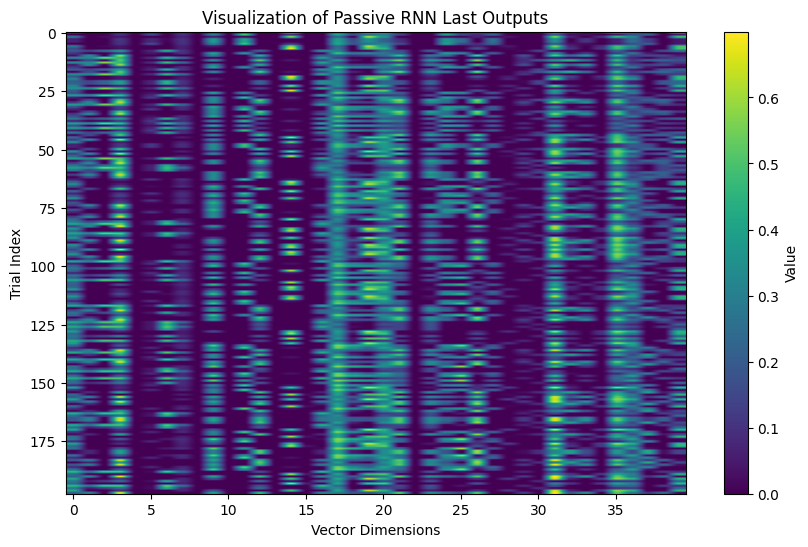

[nan nan nan nan  1.  1.  0.  1. nan nan nan nan  0.  1. nan  1.  0. nan
  1.  1.  1.  0.  1.  1.  1.  0.  0.  1. nan nan nan nan nan  1.  0.  0.
  0. nan nan nan nan nan nan nan nan nan  0.  0.  0.  0. nan nan nan nan
  1. nan  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1. nan nan
 nan nan nan  0.  1.  1.  0. nan nan nan nan nan nan nan nan nan  1.  0.
  0.  1. nan nan nan nan  1.  1.  0. nan  1.  1.  0.  0.  1.  0.  0.  0.
  1.  0.  1.  1. nan nan nan nan nan  1.  1.  0.  1. nan nan nan nan nan
 nan nan nan nan  0.  1.  0. nan nan nan nan nan  1.  0.  1.  1.  1.  1.
  1.  0.  1. nan  1.  0.  0.  1.  0.  0. nan nan nan nan nan  0.  1.  0.
  1. nan nan nan nan nan nan nan nan nan  1.  0. nan  1. nan nan nan nan
 nan  1.  1.  0. nan  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0. nan nan
 nan nan nan  0.  0.  1.  1. nan nan nan nan nan nan nan nan nan  0.  1.
  1.  0. nan nan nan nan  0. nan  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.
  1.  0.  0.  0. nan nan nan nan nan  0.  1.  0. na

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(passive_rnn_last_outs[:, :, 0, 1, 1, 0], aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.xlabel('Vector Dimensions')
plt.ylabel('Trial Index')
plt.title('Visualization of Passive RNN Last Outputs')
plt.show()
passive_index
sum(isPassive==1)
response_mapping = {'left': 0, 'right': 1, np.nan: np.nan}

# Map each response individually

#print(responses)
print(responses_num)


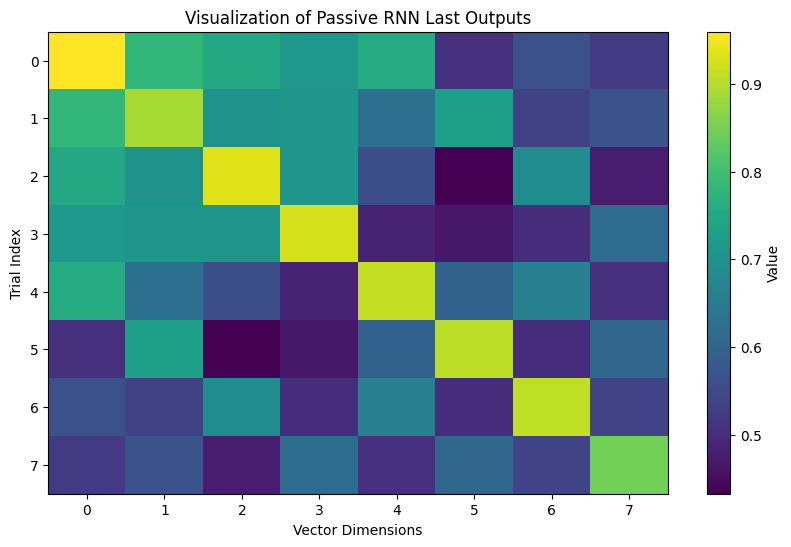

['a4_l' 'a3_l' 'b4_l' 'b3_l' 'a2a1' 'b2b1' 'b1b2' 'a1a2' 'b3_l' 'a3_l'
 'b4_l' 'a4_l' 'b3b1' 'a3a1' 'b4b2' 'b2b3' 'a1a4' 'a1a3' 'b2b4' 'b1b3'
 'a2a3' 'a4a2' 'a3a2' 'b1b4' 'a4a1' 'b4b1' 'a2a4' 'b3b2' 'a2_l' 'b3_l'
 'b1_l' 'b2_l' 'a1_l' 'b4b3' 'a3a4' 'b3b4' 'a4a3' 'b2_l' 'b1_l' 'b3_l'
 'a2_l' 'a1_l' 'b2_l' 'a4_l' 'b4_l' 'a2_l' 'b3b1' 'a3a1' 'b1b3' 'a1a3'
 'a2_l' 'b4_l' 'b2_l' 'a4_l' 'a1a4' 'b1b4' 'b1b2' 'a2a1' 'a4a1' 'b3b4'
 'a4a3' 'b2b1' 'b4b3' 'a3a2' 'a2a3' 'b3b2' 'b2b3' 'b4b1' 'a3a4' 'a1a2'
 'b3_l' 'b2_l' 'a3_l' 'a1_l' 'b1_l' 'a2a4' 'b2b4' 'a4a2' 'b4b2' 'b2_l'
 'b3_l' 'a3_l' 'a1_l' 'b1_l' 'b3_l' 'a2_l' 'a3_l' 'b2_l' 'a4a1' 'b4b1'
 'a1a4' 'b1b4' 'b3_l' 'b2_l' 'a3_l' 'a2_l' 'a1a3' 'b4b2' 'b2b1' 'b1b3'
 'a3a1' 'b3b4' 'b2b4' 'a2a4' 'b1b2' 'a3a4' 'b4b3' 'a2a1' 'a4a2' 'b3b1'
 'a4a3' 'a1a2' 'a1_l' 'a4_l' 'b1_l' 'b4_l' 'a3_l' 'a3a2' 'b2b3' 'a2a3'
 'b3b2' 'a3_l' 'a1_l' 'b4_l' 'b1_l' 'a4_l' 'b2_l' 'a1_l' 'b1_l' 'a2_l'
 'a3a4' 'b4b3' 'b3b4' 'a4a3' 'b2_l' 'a2_l' 'a1_l' 'b1_l' 'a4a1' 'b4b1'
 'b1b3

In [43]:
passive_states = np.array(states[isPassive == 1])  # Get states for passive trials
# passive_fc_hidden_outs
passive_rnn_last_outs_array = passive_rnn_last_outs[:, :, lr_idx-1, g_idx-1, fg_idx-2, 0]
all_states = np.unique(passive_states)
correlations_by_label = np.zeros((len(all_states), len(all_states)))  # Preallocate array for correlations
# Iterate over all unique labels

for lidx1, label1 in enumerate(all_states): 
    # Get indices of vectors with the current label
    label_indices1 = np.where(passive_states == label1)[0]
    vectors1 = passive_rnn_last_outs_array[label_indices1, :]
    for lidx2, label2 in enumerate(all_states):
        # Get indices of vectors with the current label
        label_indices2 = np.where(passive_states == label2)[0]

        # Extract the corresponding vectors
        vectors2 = passive_rnn_last_outs_array[label_indices2, :]
        #print(vectors.shape)
    
        # Compute pairwise correlations
        correlation_matrix = np.corrcoef(vectors1, vectors2, rowvar=True)  # Correlation matrix
        correlations_by_label[lidx1, lidx2] = np.nanmean(correlation_matrix)

#correlations_by_label['b1_l']

plt.figure(figsize=(10, 6))
plt.imshow(correlations_by_label, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.xlabel('Vector Dimensions')
plt.ylabel('Trial Index')
plt.title('Visualization of Passive RNN Last Outputs')
plt.show()

print(states)

In [36]:
print(results["pes"][csub][learning_rate][rnn_gain][fc_gain])

[66.53871154785156, 26.62459945678711, 40.430240631103516, 291.5475158691406, 95.56737518310547, 746.3221435546875, 31.673595428466797, 9.88914966583252, 7.145723819732666, 22.027177810668945, 91.35454559326172, 2201.900634765625, 43.365074157714844, 1.5219827890396118, 0.20300665497779846, 0.6709166467189789, 0.5625177621841431, 0.17002832889556885, 20272.88671875, 0.9631292819976807, 1.1240286827087402, 0.58234703540802, 0.07534158229827881, 0.31965017318725586, 0.47749507427215576, 0.09613093733787537, 0.7032344937324524, 0.14358672499656677, 0.2172485589981079, 0.4909687638282776, 0.3894731402397156, 0.1307767629623413, 0.05357837677001953, 5297.27099609375, 0.08457112312316895, 0.5754535794258118, 0.7942296862602234, 0.3593589663505554, 0.04110097885131836, 0.14697527885437012, 0.3021351099014282, 0.4942490756511688, 0.04738166928291321, 0.10580575466156006, 0.33334478735923767, 0.002746492624282837, 0.5425981730222702, 0.1932392418384552, 0.5772366523742676, 0.17742452025413513, 

### Find best Network and plot avg performance 

Indices of maximum mean accuracy: (2, 2, 2)
Maximum mean accuracy: 1.0


Text(0.5, 1.0, 'net with alpha 0.02 gain 1.0')

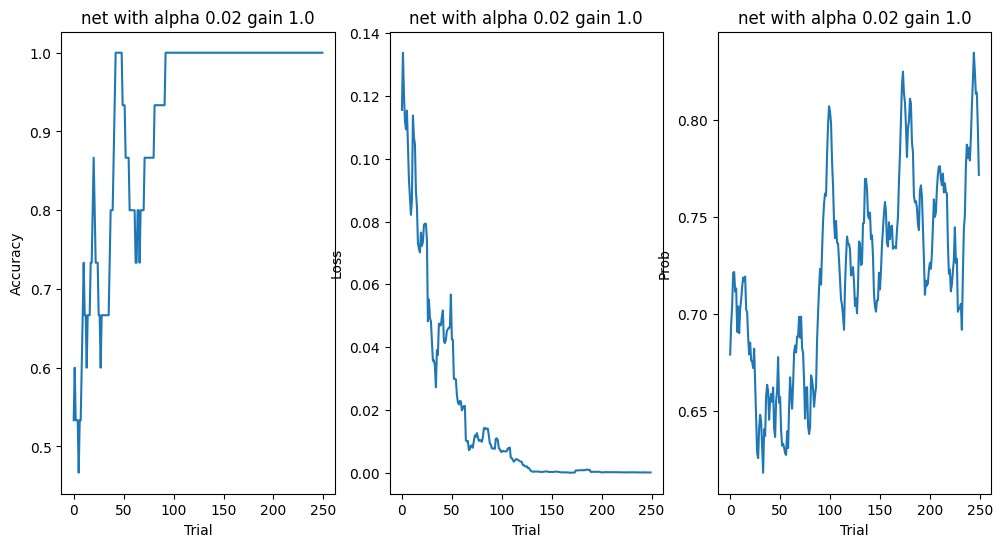

### Plot color map of net performance over param space 

[[0.63619048 0.695      0.77619048 0.8752381  0.8847619 ]
 [0.71595238 0.78261905 0.86452381 0.90547619 0.85761905]
 [0.80166667 0.85       0.8697619  0.87333333 0.72452381]
 [0.80285714 0.8552381  0.86666667 0.85095238 0.60214286]
 [0.79238095 0.82547619 0.84857143 0.81547619 0.5602381 ]]


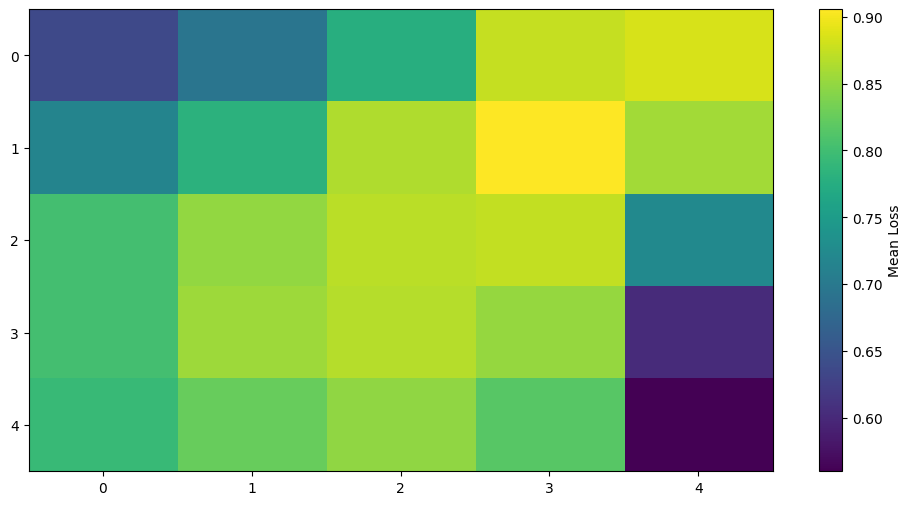

In [ ]:
cmap = np.nanmean(acc_array[:, :, :, :, 200:n_trials], axis=(2,3,4))
plt.figure(figsize=(12, 6))
plt.imshow(cmap, cmap='viridis', aspect='auto')
plt.colorbar(label='Mean Loss')
print(cmap)


### plot marginal learning curves to see variation in params 

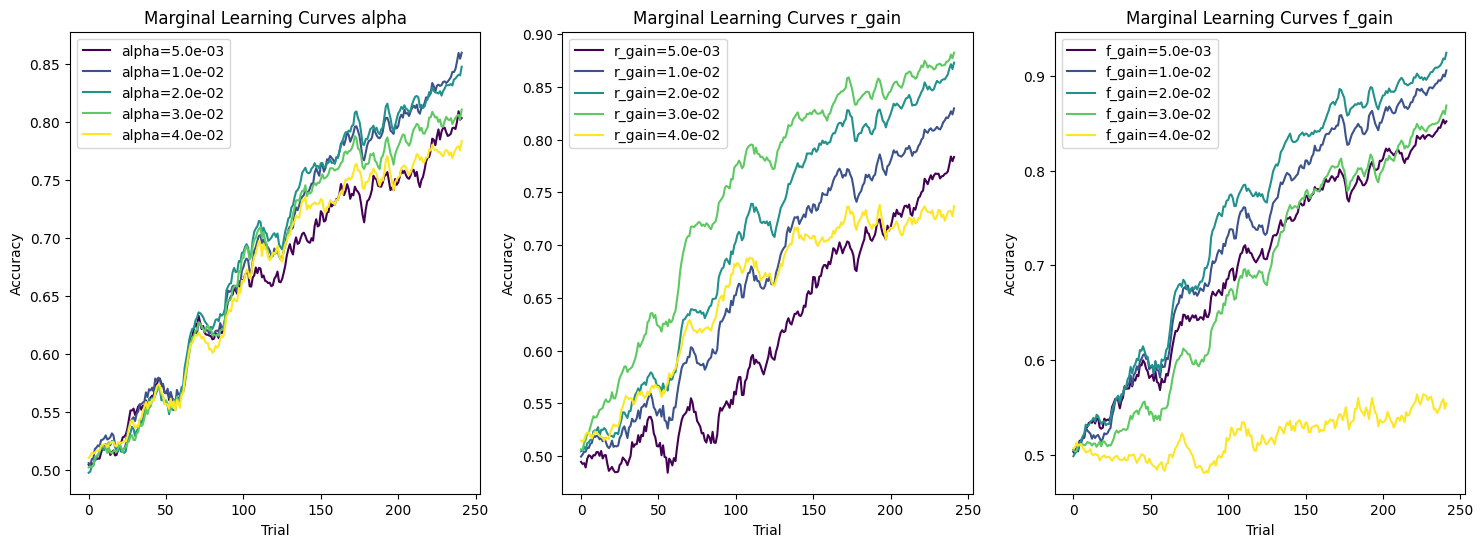

In [ ]:

mar_dim_names = ['alpha', 'r_gain', 'f_gain']  # Convert to a list for indexing
# Plot the running averages
plt.figure(figsize=(18, 6))

for cdim in range(3):
    running_avg_loss, running_avg_accuracy, dimsize = prep_marginal_means(cdim = cdim, loss_array=loss_array, acc_array=acc_array, window_size=15)
    plt.subplot(1, 3, cdim+1)
    colors = cm.viridis(np.linspace(0, 1, n_lr))  # Generate a continuous color scale
    for idx in range(dimsize):
        plt.plot(running_avg_accuracy[idx, :], label=f"{mar_dim_names[cdim]}={learning_rates[idx]:.1e}", color=colors[idx])
        plt.legend()
        plt.xlabel("Trial")
        plt.ylabel("Accuracy")
        plt.title(f"Marginal Learning Curves {mar_dim_names[cdim]}")

plt.show()

